In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
np.random.seed(10)
random_dim = 100

# Load MNIST

In [4]:
# Load the MNIST dataset and normalize each pixel value to 0-1 range.
def load_mnist():
  (x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
  x_train, x_test = (x_train-127.5)/127.5, (x_test-127.5)/127.5
  x_train = x_train.reshape((-1,28,28,1))
  x_test = x_test.reshape((-1,28,28,1))
  return (x_train, y_train, x_test, y_test)

# Generator

In [5]:
# Define a Generator
def define_generator(latent_dim):
  # takes 2 input: latent_vec and label
  # foundation of image
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(128*7*7, activation='relu', input_dim=latent_dim))
  model.add(tf.keras.layers.Reshape((7,7,128)))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.UpSampling2D())
  model.add(tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'))
  model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
  model.add(tf.keras.layers.Conv2D(1,3,padding='same',activation='tanh'))

  # label encoding
  z = tf.keras.layers.Input(shape=(latent_dim,))
  label = tf.keras.layers.Input(shape=(1,),dtype='uint8')
  label_embed = tf.keras.layers.Embedding(10, latent_dim, input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  combined = tf.keras.layers.multiply([z, label_embed])

  img = model(combined)

  return tf.keras.models.Model([z, label], img)

latent_dim = 100
g_model = define_generator(latent_dim)
g_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               1000      ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100)                  0         ['embedding[0][0]']           
                                                                                              

# Discriminator

In [6]:
# create a discriminator network to differentiate between real and fake image
def define_discriminator():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(32,(3,3),2,input_shape=(28,28,2),padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Conv2D(64,(3,3),2,padding='same'))
  model.add(tf.keras.layers.LeakyReLU(0.2))
  model.add(tf.keras.layers.Dropout(0.25))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  img = tf.keras.layers.Input(shape=(28, 28, 1))
  label = tf.keras.layers.Input(shape=(1,))
  label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28,28)), input_length=1)(label)
  label_embed = tf.keras.layers.Flatten()(label_embed)
  label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
  concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
  prediction = model(concatenated)
  return tf.keras.models.Model([img, label], prediction)

d_model = define_discriminator()
d_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 784)               7840      ['input_4[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 784)                  0         ['embedding_1[0][0]']         
                                                                                                  
 reshape_1 (Reshape)         (None, 28, 28, 1)            0         ['flatten_2[0][0]']           
                                                                                            

In [7]:
d_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [8]:
z = tf.keras.layers.Input(shape=(100,))
label = tf.keras.layers.Input(shape=(1,))
img = g_model([z, label])

d_model.trainable = False
prediction = d_model([img, label])
cgan = tf.keras.models.Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 28, 28, 1)            857193    ['input_5[0][0]',             
                                                                     'input_6[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 1)                    1633601   ['model[0][0]',         

# Split

In [9]:
x_train, y_train, x_test, y_test = load_mnist()

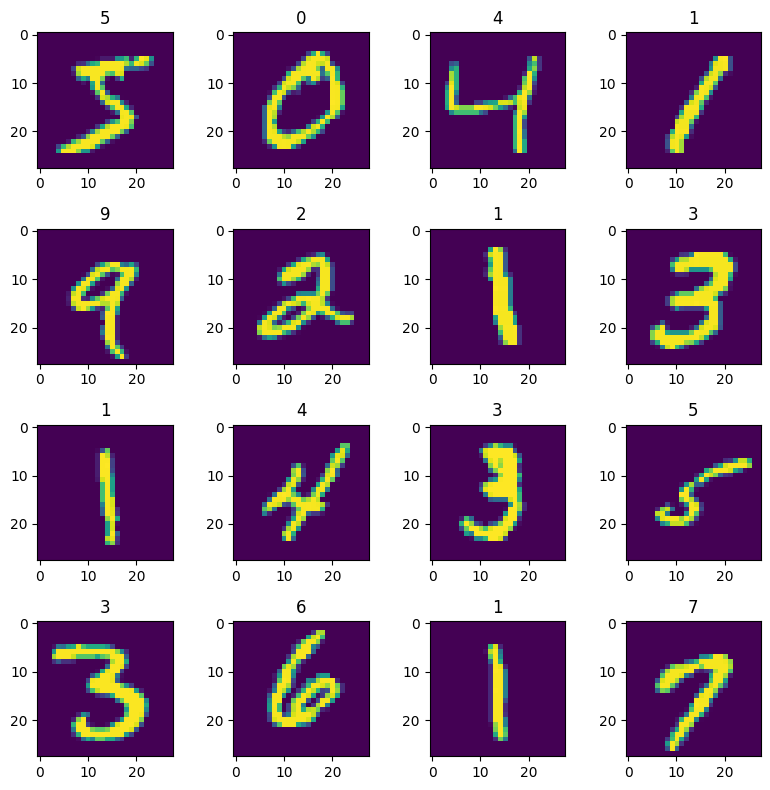

In [10]:
def plot_image(images, labels, rows, cols):
  w=10
  h=10
  fig=plt.figure(figsize=(8, 8))
  for i in range(1, cols*rows +1):
      img = images[i-1]
      ax = fig.add_subplot(rows, cols, i)
      ax.title.set_text(labels[i-1])
      plt.imshow(img.reshape((28,28)))
  fig.tight_layout()
  plt.show()

samples = x_train[:4*4]
labels = y_train[:4*4]
plot_image(samples,labels, 4,4)

# Train

(60000, 28, 28, 1)
Epochs>>>>>> 0
4/4 [==============================] - 1s 3ms/step
Losses(d,g): 0.7605248689651489 [0.2082880735397339, 1.0]
1/1 [==============================] - 0s 305ms/step


Epochs>>>>>> 1
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 2
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 3
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 4
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 7
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 8
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 9
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 10
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 11
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 12
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 14
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15
4/4 [==============================] - 0s 3ms/step
Epoc

Epochs>>>>>> 1001
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 1002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 1015
4/4 [===========

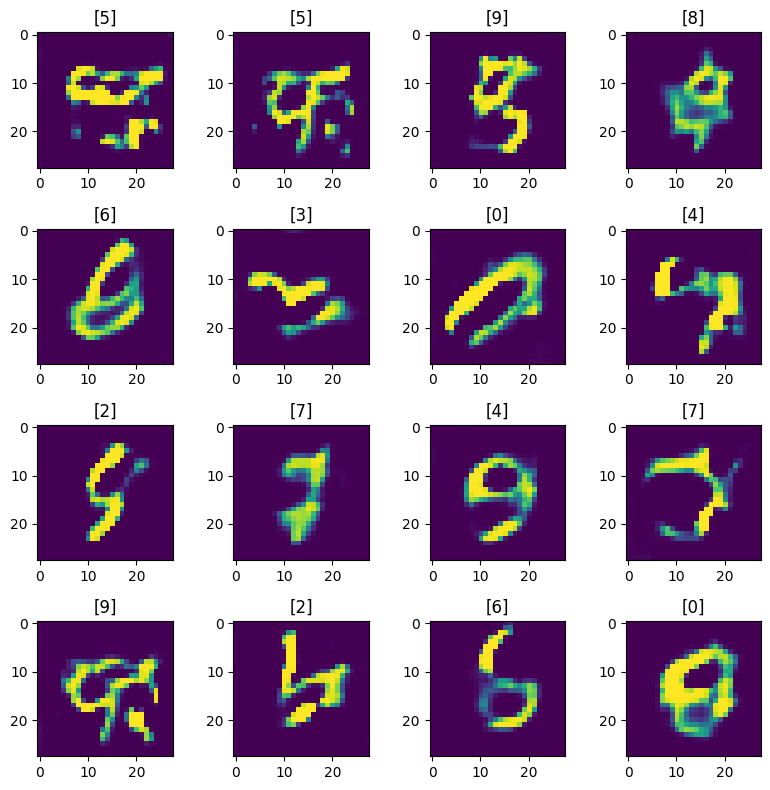

Epochs>>>>>> 2001
4/4 [==============================] - 0s 7ms/step
Epochs>>>>>> 2002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2003
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 2004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 2006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2008
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 2009
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 2010
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 2011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 2015
4/4 [===========

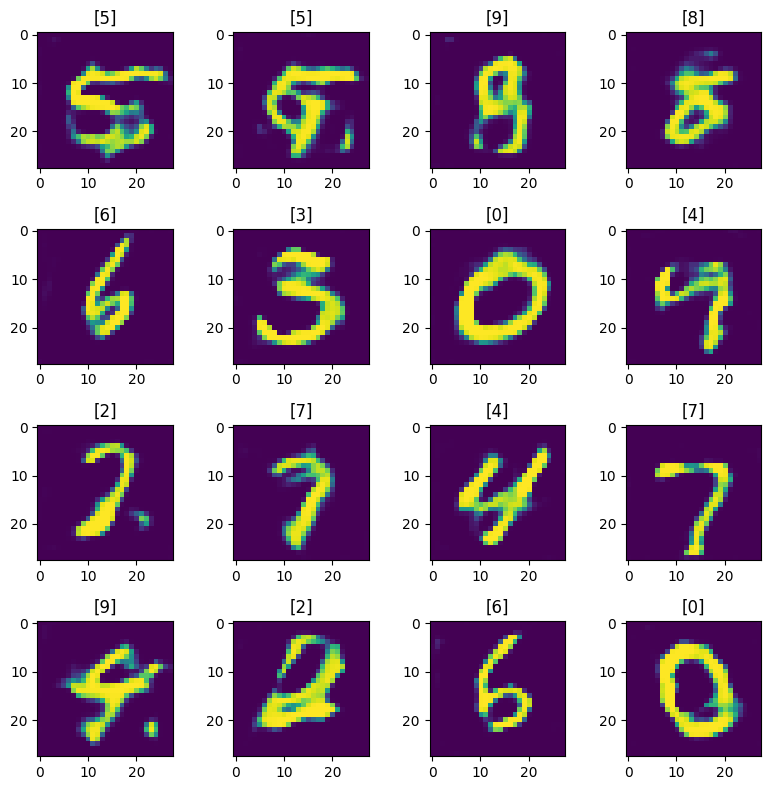

Epochs>>>>>> 3001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3002
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 3003
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 3004
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 3005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 3015
4/4 [===========

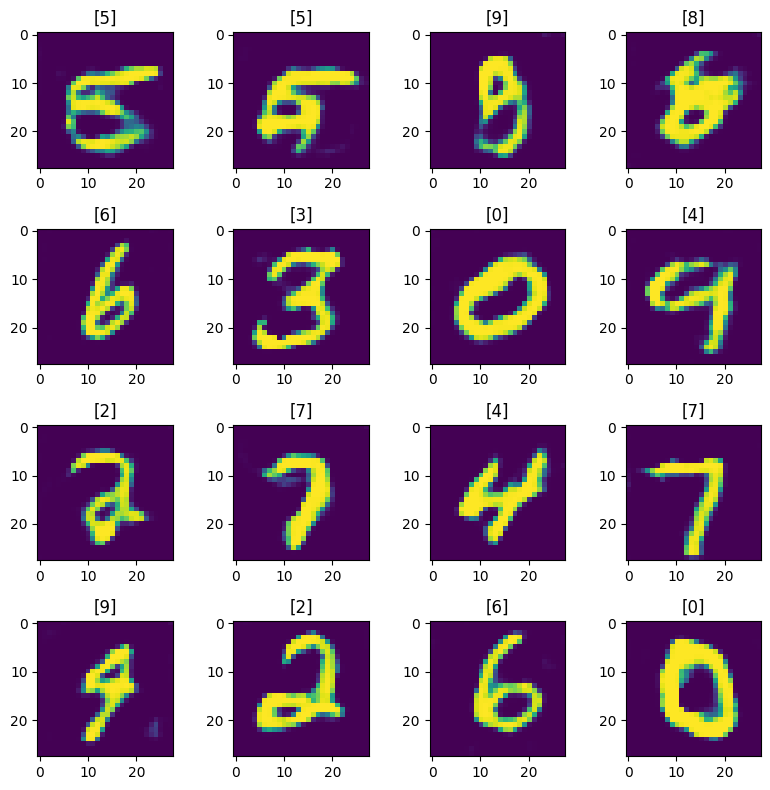

Epochs>>>>>> 4001
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 4002
4/4 [==============================] - 0s 8ms/step
Epochs>>>>>> 4003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 4004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 4005
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 4006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 4007
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 4008
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 4009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 4010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 4011
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 4012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 4013
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 4014
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 4015
4/4 [===========

Epochs>>>>>> 5001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5005
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 5006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5011
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 5012
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 5013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 5015
4/4 [===========

Epochs>>>>>> 6001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6009
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 6010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 6011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 6015
4/4 [===========

Epochs>>>>>> 7001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7004
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 7005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7010
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 7011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 7014
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 7015
4/4 [===========

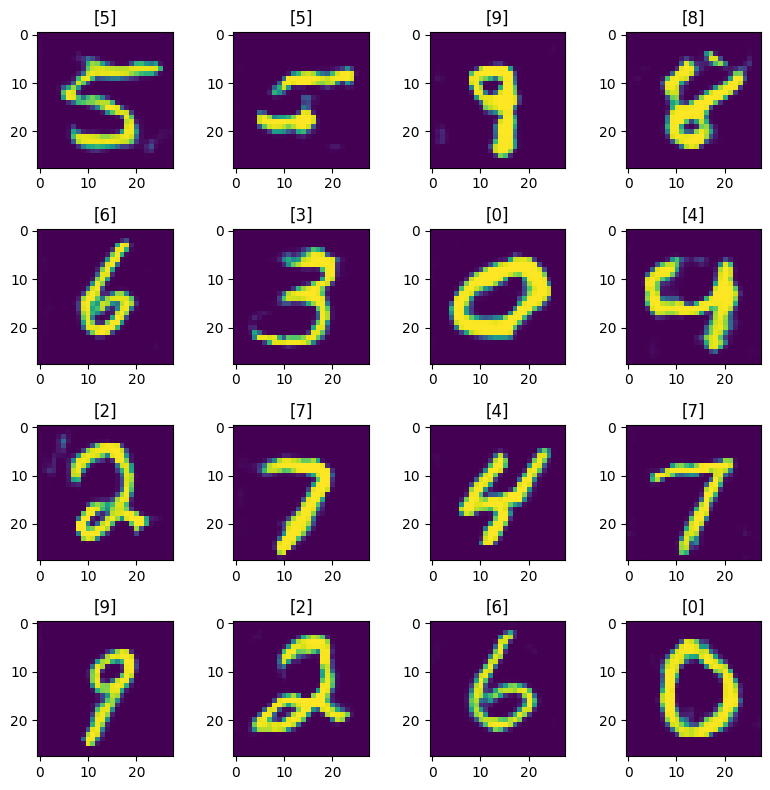

Epochs>>>>>> 8001
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 8002
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 8003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8008
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 8009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8012
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 8013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 8014
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 8015
4/4 [===========

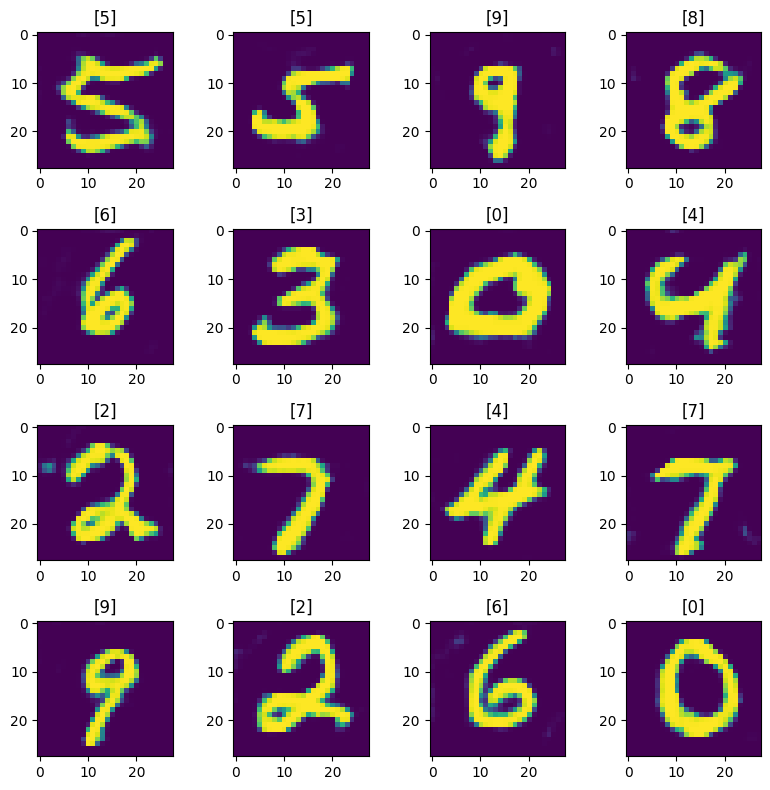

Epochs>>>>>> 9001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9004
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 9005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 9006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9007
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 9008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 9011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 9014
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 9015
4/4 [===========

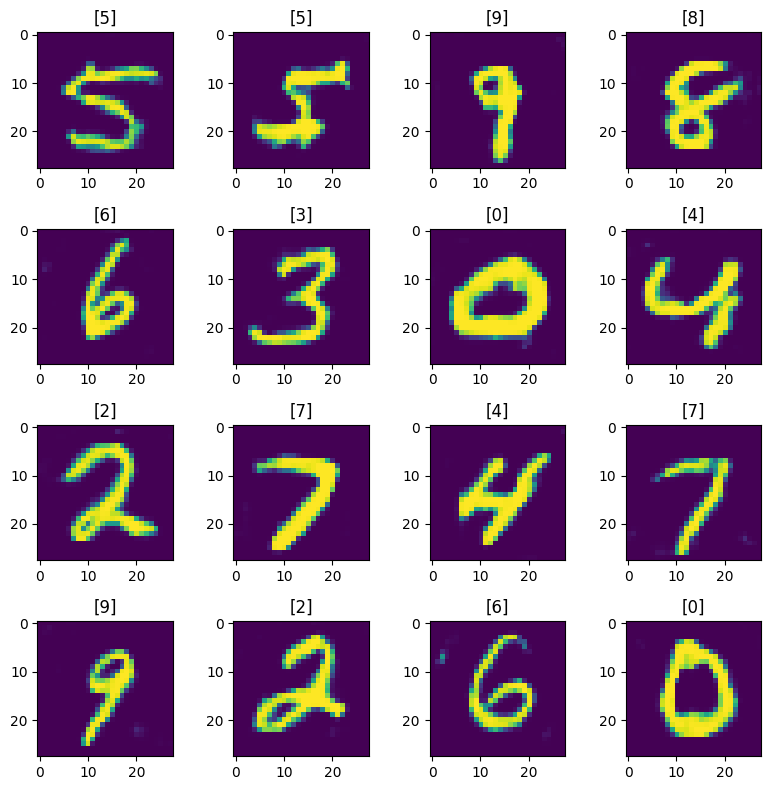

Epochs>>>>>> 10001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10005
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 10006
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 10007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10012
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 10013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 10014
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 10015
4

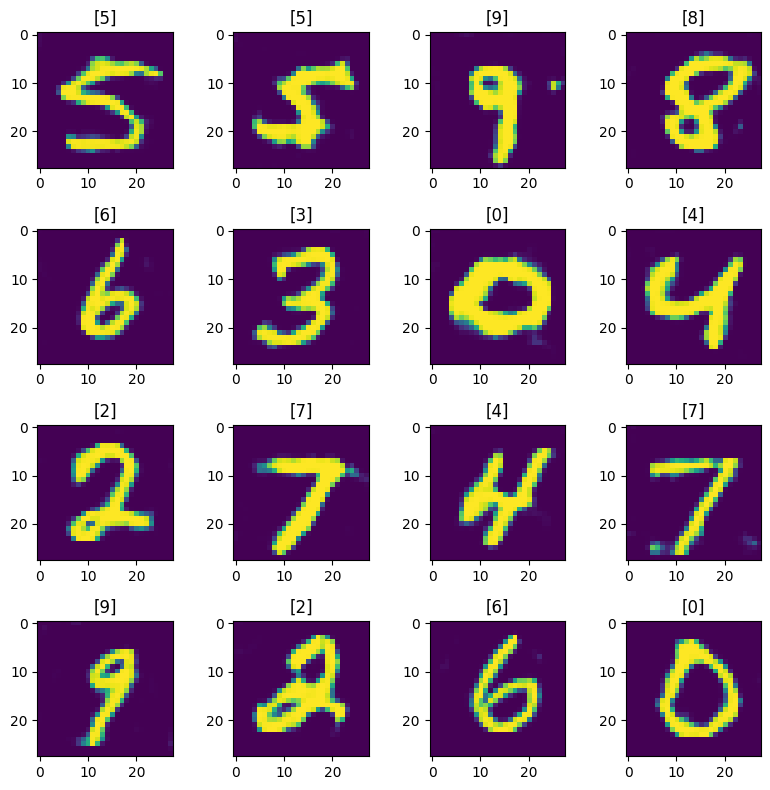

Epochs>>>>>> 11001
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 11002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 11003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 11004
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 11005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 11006
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 11007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 11008
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 11009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 11010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 11011
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 11012
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 11013
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 11014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 11015
4

Epochs>>>>>> 12001
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 12002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 12006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12012
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 12013
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 12014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 12015
4

Epochs>>>>>> 13001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13003
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 13004
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 13005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13007
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 13008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13010
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 13011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 13015
4

Epochs>>>>>> 14001
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 14002
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 14003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14009
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 14010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14013
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 14014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 14015
4

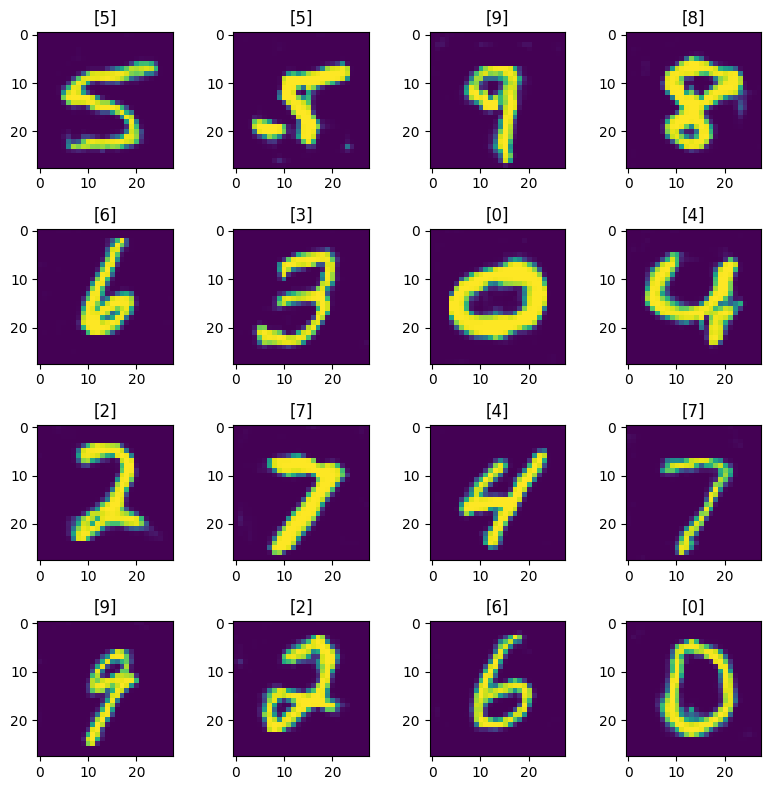

Epochs>>>>>> 15001
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 15002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 15006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15008
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 15009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15011
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 15012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15013
4/4 [==============================] - 0s 8ms/step
Epochs>>>>>> 15014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 15015
4

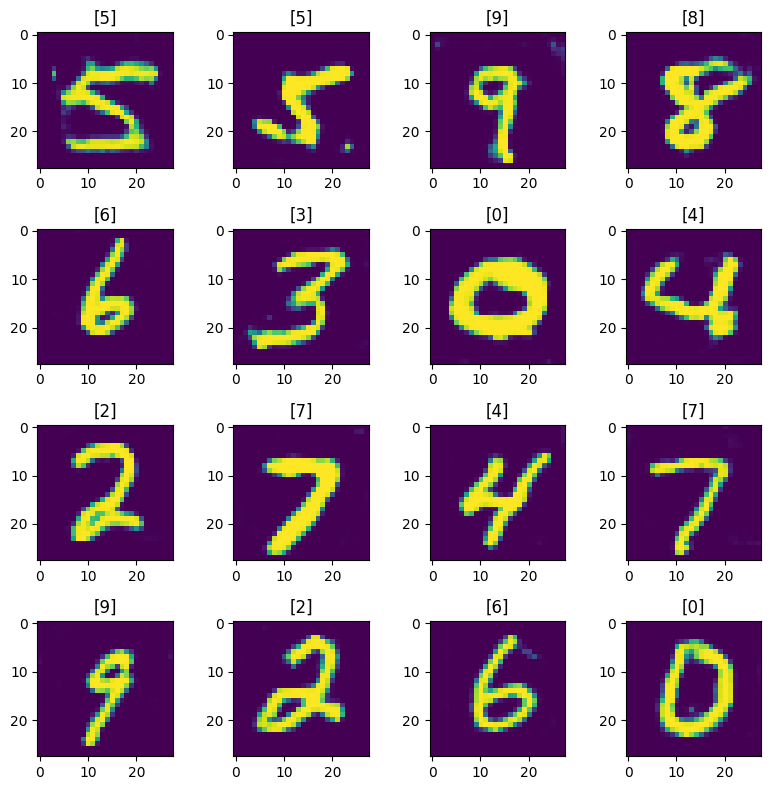

Epochs>>>>>> 16001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16006
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 16007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 16011
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 16012
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 16013
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 16014
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 16015
4

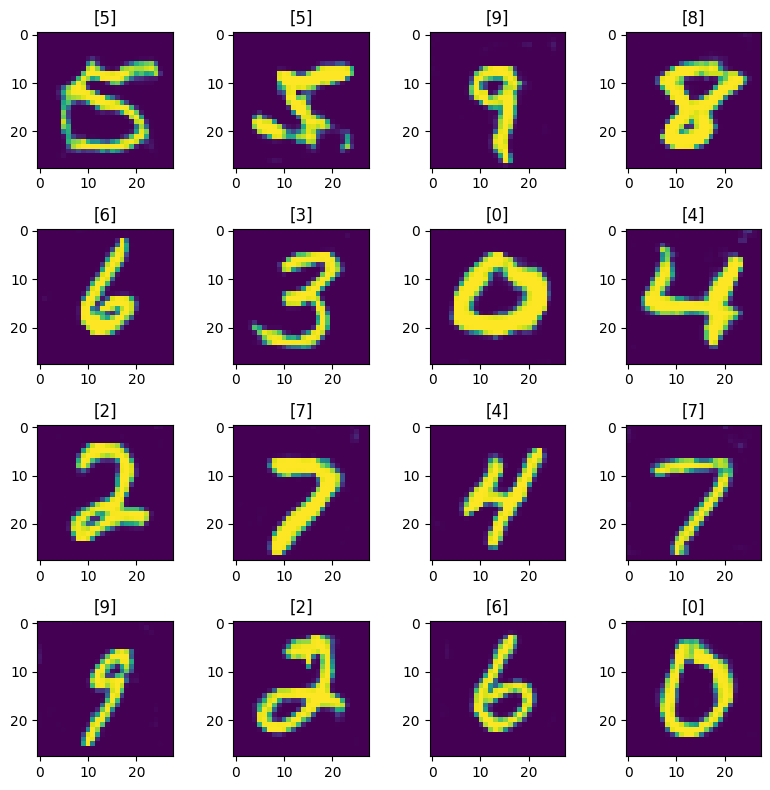

Epochs>>>>>> 17001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 17002
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 17003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 17004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 17005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 17006
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 17007
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 17008
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 17009
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 17010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 17011
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 17012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 17013
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 17014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 17015
4

Epochs>>>>>> 18001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18005
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 18006
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 18007
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 18008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18012
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 18013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 18014
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 18015
4

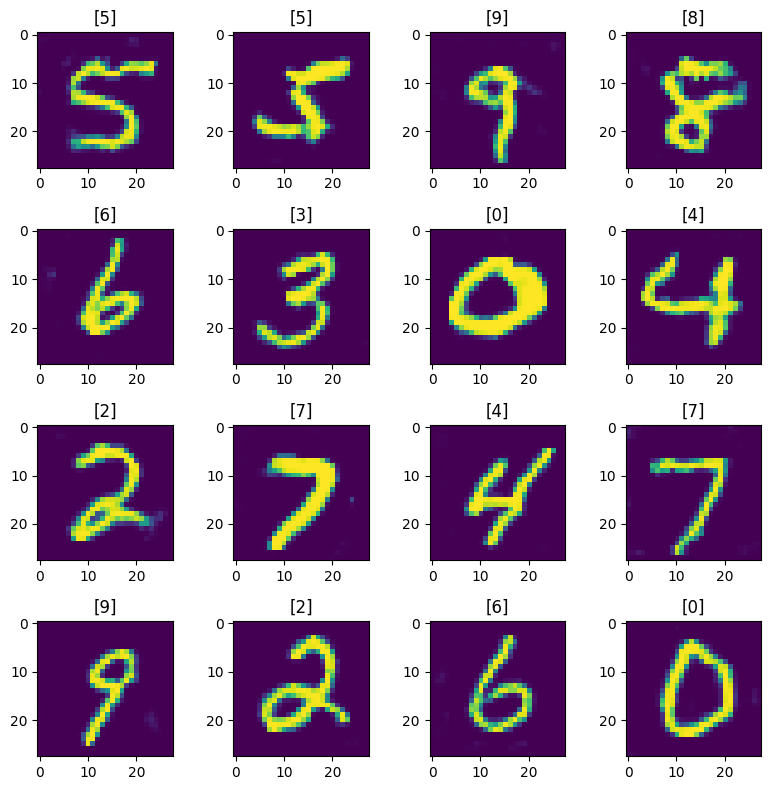

Epochs>>>>>> 19001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 19002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 19003
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 19004
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 19005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 19006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 19007
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 19008
4/4 [==============================] - 0s 7ms/step
Epochs>>>>>> 19009
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 19010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 19011
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 19012
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 19013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 19014
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 19015
4

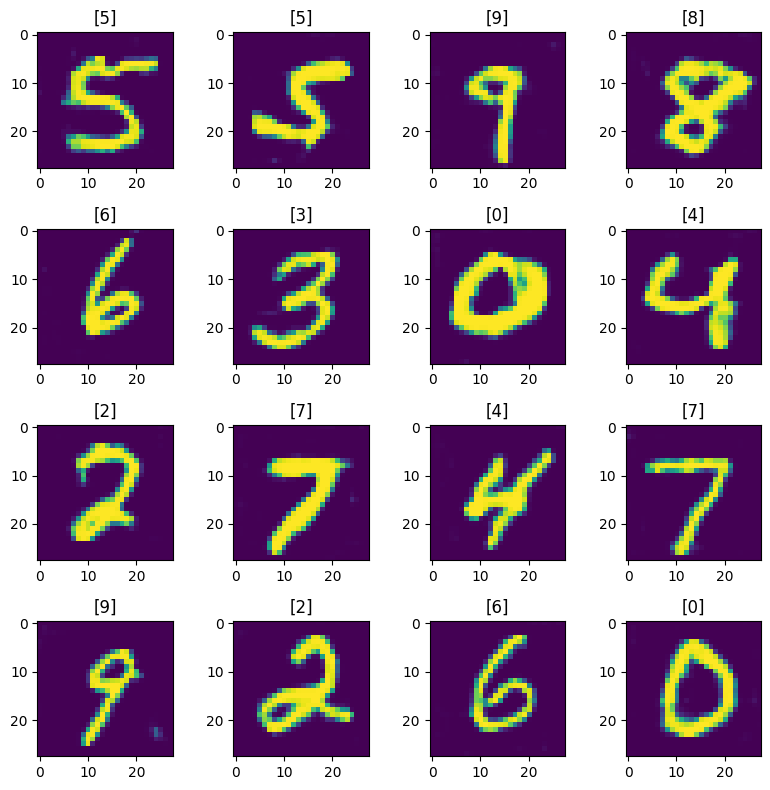

Epochs>>>>>> 20001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 20002
4/4 [==============================] - 0s 7ms/step
Epochs>>>>>> 20003
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 20004
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 20005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 20006
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 20007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 20008
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 20009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 20010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 20011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 20012
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 20013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 20014
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 20015
4

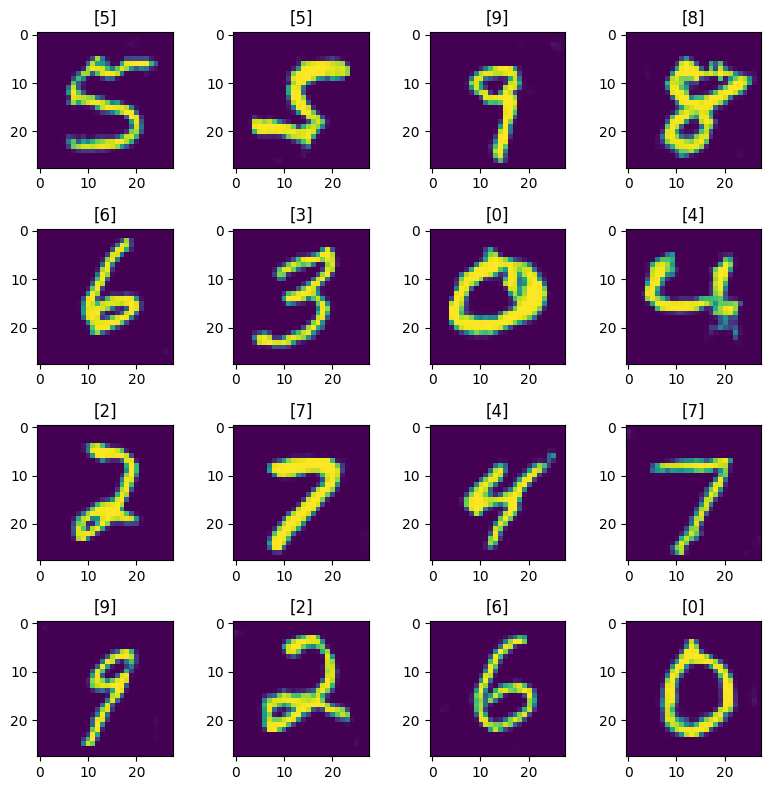

Epochs>>>>>> 21001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21006
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 21007
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 21008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21009
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 21010
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 21011
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 21012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 21015
4

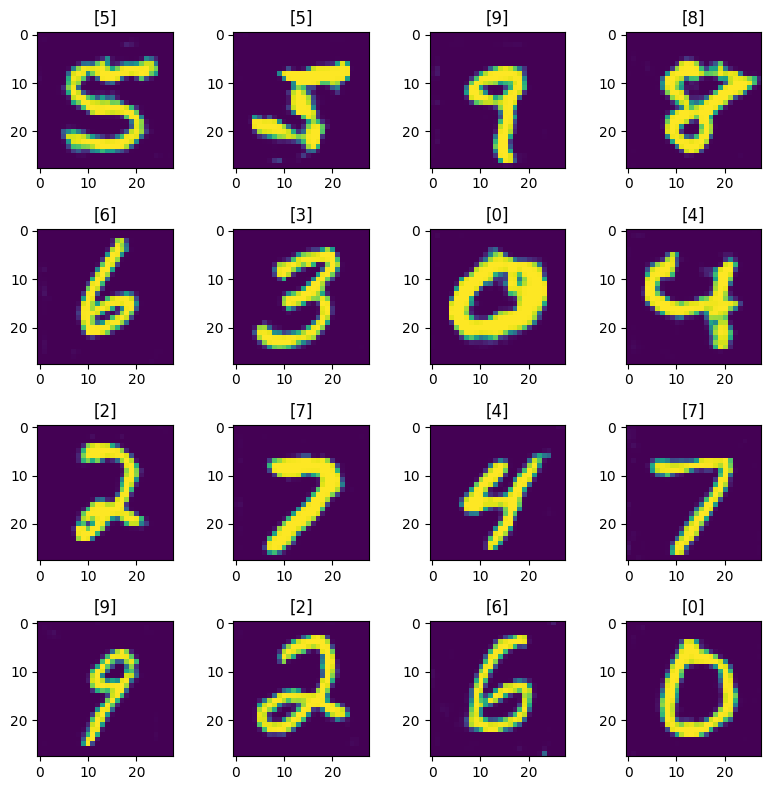

Epochs>>>>>> 22001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22002
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 22003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 22010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 22011
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 22012
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 22013
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 22014
4/4 [==============================] - 0s 8ms/step
Epochs>>>>>> 22015
4

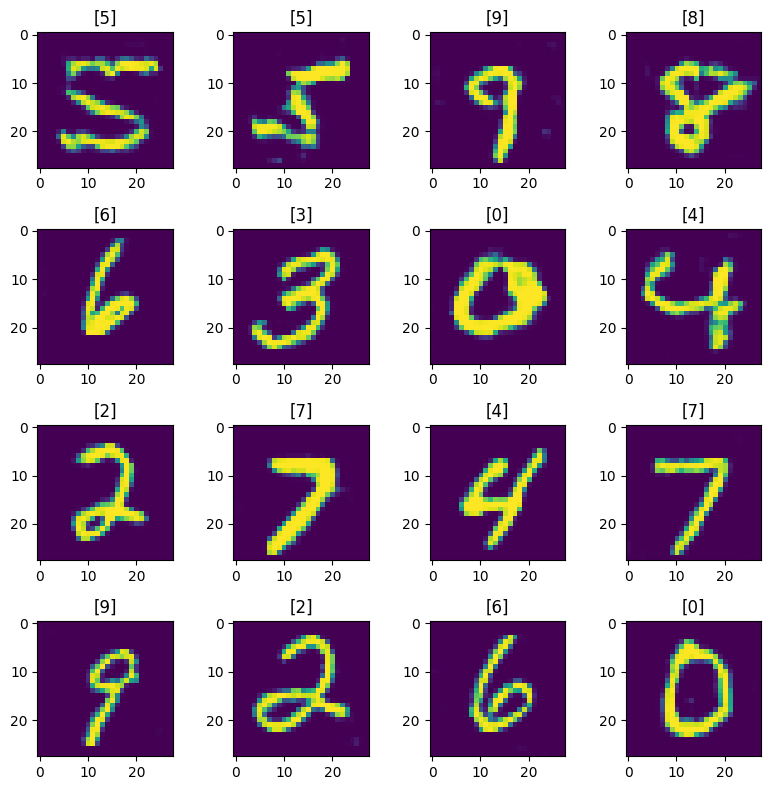

Epochs>>>>>> 23001
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 23002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 23003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 23004
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 23005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 23006
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 23007
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 23008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 23009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 23010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 23011
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 23012
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 23013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 23014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 23015
4

Epochs>>>>>> 24001
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 24002
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 24003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 24004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 24005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 24006
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 24007
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 24008
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 24009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 24010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 24011
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 24012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 24013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 24014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 24015
4

Epochs>>>>>> 25001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25003
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25006
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 25007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25008
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25009
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 25010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 25014
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 25015
4

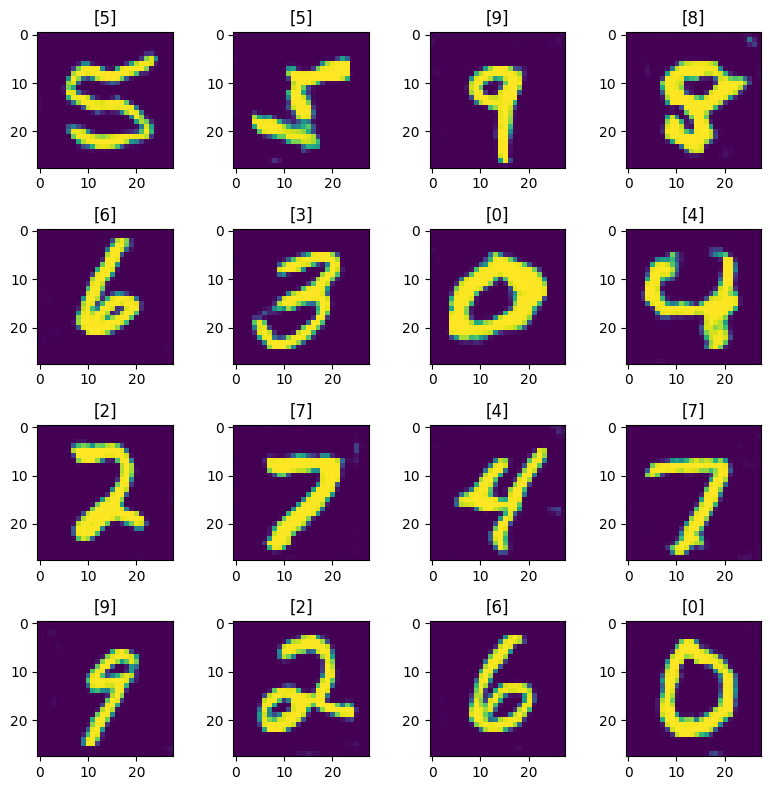

Epochs>>>>>> 26001
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 26002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 26003
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 26004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 26005
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 26006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 26007
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 26008
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 26009
4/4 [==============================] - 0s 3ms/step
Epochs>>>>>> 26010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 26011
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 26012
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 26013
4/4 [==============================] - 0s 7ms/step
Epochs>>>>>> 26014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 26015
4

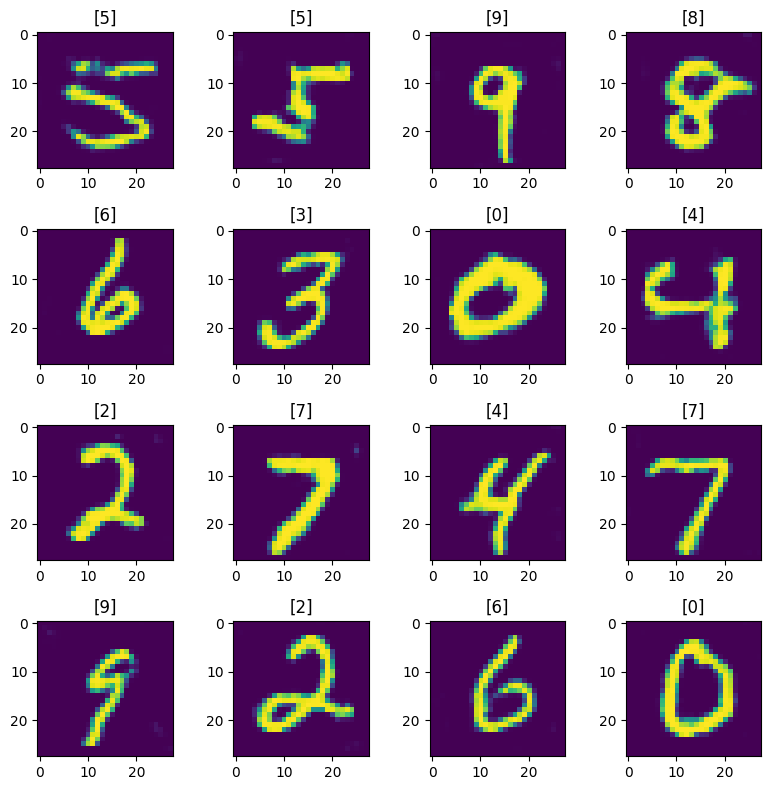

Epochs>>>>>> 27001
4/4 [==============================] - 0s 7ms/step
Epochs>>>>>> 27002
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 27003
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 27004
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 27005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 27006
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 27007
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 27008
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 27009
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 27010
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 27011
4/4 [==============================] - 0s 6ms/step
Epochs>>>>>> 27012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 27013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 27014
4/4 [==============================] - 0s 9ms/step
Epochs>>>>>> 27015
4

Epochs>>>>>> 28001
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28002
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28003
4/4 [==============================] - 0s 7ms/step
Epochs>>>>>> 28004
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28005
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 28006
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28007
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28008
4/4 [==============================] - 0s 5ms/step
Epochs>>>>>> 28009
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28010
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28011
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28012
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28013
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28014
4/4 [==============================] - 0s 4ms/step
Epochs>>>>>> 28015
4

In [11]:
import os

epochs = 29000
batch_size = 128
save_interval = 1000

print(x_train.shape)

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

losses = {"G":[], "D":[]}

samples_test = np.random.normal(0,1,(16, 100))
labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))

for epoch in range(epochs):
    print("Epochs>>>>>>",epoch)
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs, labels = x_train[idx], y_train[idx]

    noise = np.random.normal(0,1,(batch_size, 100))
    fake_imgs = g_model.predict([noise, labels])

    # train discriminator
    d_model.trainable = True
    d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
    d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    d_model.trainable = False

    z = np.random.normal(0,1, size=(batch_size, 100))
    labels = np.random.randint(0, 10, batch_size).reshape((-1, 1))

    # train generator
    g_loss = cgan.train_on_batch([z, labels], valid)

    losses["G"].append(g_loss)
    losses["D"].append(d_loss)

    if epoch % save_interval == 0:
        print("Losses(d,g):", d_loss[0], g_loss)
        results = g_model.predict([samples_test, labels_test])
        plot_image(results, labels_test, 4, 4)

In [12]:
d_model.save('/content/drive/MyDrive/discriminator.h5')
g_model.save('/content/drive/MyDrive/generator.h5')
cgan.save('/content/drive/MyDrive/cgan.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
